<a href="https://colab.research.google.com/github/aaronpetryio/random/blob/main/mmlm_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Introduction

*   This notebook is inspired by the 2nd Place NCAAW 2021 notebook built by Theo Viel
*   I am copying the notebook and their work to learn and enter a model into the 2023 competition
*   The notebook I am copying can be found [HERE](https://www.kaggle.com/code/theoviel/2nd-place-ncaaw-2021?scriptVersionId=58780991)


#### Import Libraries

In [1]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.model_selection import *

#### Connect to Kaggle and download data

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aaronpetryio","key":"ac3f073bb1dfa9030d82b13d6f357d21"}'}

In [4]:
!mkdir ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c march-machine-learning-mania-2023

 18% 5.00M/28.5M [00:00<00:01, 16.1MB/s]
100% 28.5M/28.5M [00:00<00:00, 74.9MB/s]


In [8]:
!unzip march-machine-learning-mania-2023.zip

Archive:  march-machine-learning-mania-2023.zip
  inflating: Cities.csv              
  inflating: Conferences.csv         
  inflating: MConferenceTourneyGames.csv  
  inflating: MGameCities.csv         
  inflating: MMasseyOrdinals_thru_Season2023_Day128.csv  
  inflating: MNCAATourneyCompactResults.csv  
  inflating: MNCAATourneyDetailedResults.csv  
  inflating: MNCAATourneySeedRoundSlots.csv  
  inflating: MNCAATourneySeeds.csv   
  inflating: MNCAATourneySlots.csv   
  inflating: MRegularSeasonCompactResults.csv  
  inflating: MRegularSeasonDetailedResults.csv  
  inflating: MSeasons.csv            
  inflating: MSecondaryTourneyCompactResults.csv  
  inflating: MSecondaryTourneyTeams.csv  
  inflating: MTeamCoaches.csv        
  inflating: MTeamConferences.csv    
  inflating: MTeamSpellings.csv      
  inflating: MTeams.csv              
  inflating: SampleSubmission2023.csv  
  inflating: WGameCities.csv         
  inflating: WNCAATourneyCompactResults.csv  
  inflating: WNCAA

#### EDA / Data Cleaning

In [9]:
df_results_w = pd.read_csv("WRegularSeasonCompactResults.csv")
df_results_m = pd.read_csv("MRegularSeasonCompactResults.csv")

In [10]:
df_results_full = pd.concat([df_results_w, df_results_m], axis=0)

In [11]:
df_results_full.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1998,18,3104,91,3202,41,H,0
1,1998,18,3163,87,3221,76,H,0
2,1998,18,3222,66,3261,59,H,0
3,1998,18,3307,69,3365,62,H,0
4,1998,18,3349,115,3411,35,H,0


#### Add Data Columns

In [12]:
df_results_full['ScoreGap'] = df_results_full['WScore'] - df_results_full['LScore']

In [13]:
num_wins = df_results_full.groupby(['Season', 'WTeamID']).count()
num_wins = num_wins.reset_index()[['Season', 'WTeamID', 'DayNum']].rename(columns = {"WTeamID": "TeamID", "DayNum": "NumWins"})

In [14]:
num_wins.head()

,Season,TeamID,NumWins
0,1985,1102,5
1,1985,1103,9
2,1985,1104,21
3,1985,1106,10
4,1985,1108,19


In [15]:
num_losses = df_results_full.groupby(['Season', 'LTeamID']).count().reset_index()
num_losses = num_losses[['Season', 'LTeamID', 'DayNum']].rename(columns = {"LTeamID": "TeamID", "DayNum": "NumLosses"})

In [16]:
num_losses.head()

,Season,TeamID,NumLosses
0,1985,1102,19
1,1985,1103,14
2,1985,1104,9
3,1985,1106,14
4,1985,1108,6


In [17]:
win_gap = df_results_full.groupby(['Season', 'WTeamID']).mean().reset_index()
win_gap = win_gap[['Season', 'WTeamID', 'ScoreGap']].rename(columns = {"WTeamID": "TeamID", "ScoreGap": "WinGap"})

In [18]:
loss_gap = df_results_full.groupby(['Season', 'LTeamID']).mean().reset_index()
loss_gap = loss_gap[['Season', 'LTeamID', 'ScoreGap']].rename(columns = {"LTeamID": "TeamID", "ScoreGap": "LossGap"})

#### Create a dataframe of all teams and seasons and merge features on Season/TeamID

In [19]:
df_results_w = df_results_full.groupby(['Season', 'WTeamID']).count().reset_index()[['Season', 'WTeamID']].rename(columns={"WTeamID": "TeamID"})
df_results_l = df_results_full.groupby(['Season', 'LTeamID']).count().reset_index()[['Season', 'LTeamID']].rename(columns={"LTeamID": "TeamID"})

In [20]:
df_features_full = pd.concat([df_results_w, df_results_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)

<ipython-input-20-60ecc23d295d>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df_features_full = pd.concat([df_results_w, df_results_l], 0).drop_duplicates().sort_values(['Season', 'TeamID']).reset_index(drop=True)


In [21]:
df_features_full.describe()

,Season,TeamID
count,21428.000000,21428.000000
mean,2007.286681,2103.063282
std,10.259229,988.882093
min,1985.000000,1101.000000
25%,2000.000000,1257.000000
50%,2008.000000,1410.000000
75%,2016.000000,3245.000000
max,2023.000000,3477.000000


In [22]:
df_features_full = df_features_full.merge(num_wins, on=['Season', 'TeamID'], how='left')
df_features_full = df_features_full.merge(num_losses, on=['Season', 'TeamID'], how='left')
df_features_full = df_features_full.merge(win_gap, on=['Season', 'TeamID'], how='left')
df_features_full = df_features_full.merge(loss_gap, on=['Season', 'TeamID'], how='left')

In [23]:
df_features_full.fillna(0, inplace=True)

#### Build the Win Ratio and Gap Average columns

In [24]:
df_features_full['WinRatio'] = df_features_full['NumWins'] / (df_features_full['NumWins'] + df_features_full['NumLosses'])

In [25]:
df_features_full['GapAvg'] = (
    (df_features_full['NumWins'] * df_features_full['WinGap'] - df_features_full['NumLosses'] * df_features_full['LossGap'])
    / (df_features_full['NumWins'] + df_features_full['NumLosses'])
)

In [26]:
df_features_full.head()

,Season,TeamID,NumWins,NumLosses,WinGap,LossGap,WinRatio,GapAvg
0,1985,1102,5.0,19.0,10.000000,9.947368,0.208333,-5.791667
1,1985,1103,9.0,14.0,7.555556,9.857143,0.391304,-3.043478
2,1985,1104,21.0,9.0,13.190476,4.777778,0.700000,7.800000
3,1985,1106,10.0,14.0,9.500000,13.285714,0.416667,-3.791667
4,1985,1108,19.0,6.0,13.842105,10.666667,0.760000,7.960000


#### Collect Historic Tourney Results

In [27]:
df_tourney_results_w = pd.read_csv("WNCAATourneyCompactResults.csv")
df_tourney_results_m = pd.read_csv("MNCAATourneyCompactResults.csv")

In [28]:
df_tourney_results_full = pd.concat([df_tourney_results_w, df_tourney_results_m], axis=0)

In [29]:
df_tourney_results_full.drop(['NumOT', 'WLoc'], axis=1, inplace=True)

In [30]:
df_tourney_results_full.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore
0,1998,137,3104,94,3422,46
1,1998,137,3112,75,3365,63
2,1998,137,3163,93,3193,52
3,1998,137,3198,59,3266,45
4,1998,137,3203,74,3208,72


#### Collect Tournament Seeds

In [31]:
df_seeds_w = pd.read_csv("WNCAATourneySeeds.csv")
df_seeds_m = pd.read_csv("MNCAATourneySeeds.csv")

In [32]:
df_seeds_full = pd.concat([df_seeds_w, df_seeds_m], axis=0)

In [33]:
df_seeds_full.head()

,Season,Seed,TeamID
0,1998,W01,3330
1,1998,W02,3163
2,1998,W03,3112
3,1998,W04,3301
4,1998,W05,3272


#### Begin Feature Engineering

In [34]:
# Copy the tourney results to a new dataframe
df = df_tourney_results_full.copy()

In [35]:
# Drop any results older than 2016
df = df[df['Season'] >= 2016].reset_index(drop=True)

In [36]:
# Add the tournament seeds to the winning teams in the dataframe
df = pd.merge(
    df,
    df_seeds_full,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed':'SeedW'})

In [37]:
# Add the tournament seeds to the losing teams in the dataframe
df = pd.merge(
    df,
    df_seeds_full,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed':'SeedL'})

In [38]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL
0,2016,137,3107,61,3196,59,Z12,Z05
1,2016,137,3113,74,3308,52,Z02,Z15
2,2016,137,3120,68,3385,57,X09,X08
3,2016,137,3124,89,3225,59,X01,X16
4,2016,137,3177,97,3241,67,X06,X11


In [39]:
# Write a function to remove any alphanumeric character from the seeds (ie. Change from Z12 to 12)
def fix_seed(seed):
  return int(re.sub("[^0-9]", "", seed))

In [40]:
# Apply the fix to the seeds in the dataframe
df['SeedW'] = df['SeedW'].apply(fix_seed)
df['SeedL'] = df['SeedL'].apply(fix_seed)

In [41]:
# Add the season stats (wins, losses, avg. win gap, avg. loss gap, win ratio, average gap) to the winning teams 
df = pd.merge(
    df,
    df_features_full,
    how='left',
    left_on=['Season', 'WTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins' : 'NumWinsW',
    'NumLosses' : 'NumLossesW',
    'WinGap' : 'WinGapW',
    'LossGap' : 'LossGapW',
    'WinRatio' : 'WinRatioW',
    'GapAvg' : 'GapAvgW'
}).drop(columns='TeamID', axis=1)

In [42]:
# Add the season stats (wins, losses, avg. win gap, avg. loss gap, win ratio, average gap) to the losing teams 
df = pd.merge(
    df,
    df_features_full,
    how='left',
    left_on=['Season', 'LTeamID'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins' : 'NumWinsL',
    'NumLosses' : 'NumLossesL',
    'WinGap' : 'WinGapL',
    'LossGap' : 'LossGapL',
    'WinRatio' : 'WinRatioL',
    'GapAvg' : 'GapAvgL'
}).drop(columns='TeamID', axis=1)

In [43]:
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinGapW,LossGapW,WinRatioW,GapAvgW,NumWinsL,NumLossesL,WinGapL,LossGapL,WinRatioL,GapAvgL
0,2016,137,3107,61,3196,59,12,5,27.0,4.0,22.333333,6.000000,0.870968,18.677419,22.0,8.0,16.772727,13.500000,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,25.0,6.0,13.960000,10.333333,0.806452,9.258065,24.0,4.0,12.416667,11.750000,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,19.0,12.0,13.421053,13.416667,0.612903,3.032258,23.0,9.0,12.956522,8.888889,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,33.0,1.0,25.575758,7.000000,0.970588,24.617647,22.0,9.0,19.818182,11.888889,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,25.0,8.0,24.640000,9.875000,0.757576,16.272727,27.0,5.0,20.740741,13.400000,0.843750,15.406250


#### Make data symmetrical (ie. duplicate data and eliminate W/L)

In [44]:
def add_losses(df):
  win_rename = {
      "WTeamID" : "TeamIdA",
      "WScore" : "ScoreA",
      "LTeamID" : "TeamIdB",
      "LScore" : "ScoreB",
  }

  win_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('W')})
  win_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('L')})

  loss_rename = {
      "WTeamID" : "TeamIdB",
      "WScore" : "ScoreB",
      "LTeamID" : "TeamIdA",
      "LScore" : "ScoreA",
  }

  loss_rename.update({c : c[:-1] + "B" for c in df.columns if c.endswith('W')})
  loss_rename.update({c : c[:-1] + "A" for c in df.columns if c.endswith('L')})

  win_df = df.copy()
  loss_df = df.copy()

  win_df = win_df.rename(columns=win_rename)
  loss_df = loss_df.rename(columns=loss_rename)

  return pd.concat([win_df, loss_df], 0, sort=False)

In [45]:
# Before the symmetrical change
df.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,SeedW,SeedL,NumWinsW,NumLossesW,WinGapW,LossGapW,WinRatioW,GapAvgW,NumWinsL,NumLossesL,WinGapL,LossGapL,WinRatioL,GapAvgL
0,2016,137,3107,61,3196,59,12,5,27.0,4.0,22.333333,6.000000,0.870968,18.677419,22.0,8.0,16.772727,13.500000,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,25.0,6.0,13.960000,10.333333,0.806452,9.258065,24.0,4.0,12.416667,11.750000,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,19.0,12.0,13.421053,13.416667,0.612903,3.032258,23.0,9.0,12.956522,8.888889,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,33.0,1.0,25.575758,7.000000,0.970588,24.617647,22.0,9.0,19.818182,11.888889,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,25.0,8.0,24.640000,9.875000,0.757576,16.272727,27.0,5.0,20.740741,13.400000,0.843750,15.406250


In [46]:
# Apply the change
df = add_losses(df)

<ipython-input-44-9f74be33ac9d>:28: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  return pd.concat([win_df, loss_df], 0, sort=False)


In [47]:
# After the symmetrical change
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,NumWinsA,NumLossesA,WinGapA,LossGapA,WinRatioA,GapAvgA,NumWinsB,NumLossesB,WinGapB,LossGapB,WinRatioB,GapAvgB
0,2016,137,3107,61,3196,59,12,5,27.0,4.0,22.333333,6.000000,0.870968,18.677419,22.0,8.0,16.772727,13.500000,0.733333,8.700000
1,2016,137,3113,74,3308,52,2,15,25.0,6.0,13.960000,10.333333,0.806452,9.258065,24.0,4.0,12.416667,11.750000,0.857143,8.964286
2,2016,137,3120,68,3385,57,9,8,19.0,12.0,13.421053,13.416667,0.612903,3.032258,23.0,9.0,12.956522,8.888889,0.718750,6.812500
3,2016,137,3124,89,3225,59,1,16,33.0,1.0,25.575758,7.000000,0.970588,24.617647,22.0,9.0,19.818182,11.888889,0.709677,10.612903
4,2016,137,3177,97,3241,67,6,11,25.0,8.0,24.640000,9.875000,0.757576,16.272727,27.0,5.0,20.740741,13.400000,0.843750,15.406250


In [48]:
# Compute the difference between the teams for each feature 
cols_diff = [
    'WinRatio', 'GapAvg'
]

for col in cols_diff:
  df[col + 'Diff'] = df[col + 'A'] - df[col + 'B']

In [49]:
df.head()

,Season,DayNum,TeamIdA,ScoreA,TeamIdB,ScoreB,SeedA,SeedB,NumWinsA,NumLossesA,...,WinRatioA,GapAvgA,NumWinsB,NumLossesB,WinGapB,LossGapB,WinRatioB,GapAvgB,WinRatioDiff,GapAvgDiff
0,2016,137,3107,61,3196,59,12,5,27.0,4.0,...,0.870968,18.677419,22.0,8.0,16.772727,13.500000,0.733333,8.700000,0.137634,9.977419
1,2016,137,3113,74,3308,52,2,15,25.0,6.0,...,0.806452,9.258065,24.0,4.0,12.416667,11.750000,0.857143,8.964286,-0.050691,0.293779
2,2016,137,3120,68,3385,57,9,8,19.0,12.0,...,0.612903,3.032258,23.0,9.0,12.956522,8.888889,0.718750,6.812500,-0.105847,-3.780242
3,2016,137,3124,89,3225,59,1,16,33.0,1.0,...,0.970588,24.617647,22.0,9.0,19.818182,11.888889,0.709677,10.612903,0.260911,14.004744
4,2016,137,3177,97,3241,67,6,11,25.0,8.0,...,0.757576,16.272727,27.0,5.0,20.740741,13.400000,0.843750,15.406250,-0.086174,0.866477


#### Prepare the Test Data

In [52]:
df_test = pd.read_csv("SampleSubmission2023.csv")

In [54]:
df_test.head()

,ID,Pred
0,2023_1101_1102,0.5
1,2023_1101_1103,0.5
2,2023_1101_1104,0.5
3,2023_1101_1105,0.5
4,2023_1101_1106,0.5


In [55]:
# Extract the Season, TeamIdA, and TeamIdB from the ID
df_test['Season'] = df_test['ID'].apply(lambda x: int(x.split('_')[0]))
df_test['TeamIdA'] = df_test['ID'].apply(lambda x: int(x.split('_')[1]))
df_test['TeamIdB'] = df_test['ID'].apply(lambda x: int(x.split('_')[2]))

In [56]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB
0,2023_1101_1102,0.5,2023,1101,1102
1,2023_1101_1103,0.5,2023,1101,1103
2,2023_1101_1104,0.5,2023,1101,1104
3,2023_1101_1105,0.5,2023,1101,1105
4,2023_1101_1106,0.5,2023,1101,1106


In [57]:
# Add the tournament seeds to the winning teams in the test dataframe
df_test = pd.merge(
    df_test,
    df_seeds_full,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed':'SeedA'})

In [58]:
# Add the tournament seeds to the losing teams in the test dataframe
df_test = pd.merge(
    df_test,
    df_seeds_full,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).drop('TeamID', axis=1).rename(columns={'Seed':'SeedB'})

In [59]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB
0,2023_1101_1102,0.5,2023,1101,1102,NaN,NaN
1,2023_1101_1103,0.5,2023,1101,1103,NaN,NaN
2,2023_1101_1104,0.5,2023,1101,1104,NaN,X01
3,2023_1101_1105,0.5,2023,1101,1105,NaN,NaN
4,2023_1101_1106,0.5,2023,1101,1106,NaN,NaN


In [60]:
# Add the season stats (wins, losses, avg. win gap, avg. loss gap, win ratio, average gap) to the winning teams 
df_test = pd.merge(
    df_test,
    df_features_full,
    how='left',
    left_on=['Season', 'TeamIdA'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins' : 'NumWinsA',
    'NumLosses' : 'NumLossesA',
    'WinGap' : 'WinGapA',
    'LossGap' : 'LossGapA',
    'WinRatio' : 'WinRatioA',
    'GapAvg' : 'GapAvgA'
}).drop(columns='TeamID', axis=1)

In [61]:
# Add the season stats (wins, losses, avg. win gap, avg. loss gap, win ratio, average gap) to the losing teams 
df_test = pd.merge(
    df_test,
    df_features_full,
    how='left',
    left_on=['Season', 'TeamIdB'],
    right_on=['Season', 'TeamID']
).rename(columns={
    'NumWins' : 'NumWinsB',
    'NumLosses' : 'NumLossesB',
    'WinGap' : 'WinGapB',
    'LossGap' : 'LossGapB',
    'WinRatio' : 'WinRatioB',
    'GapAvg' : 'GapAvgB'
}).drop(columns='TeamID', axis=1)

In [62]:
# Compute the difference between the teams for each feature 
for col in cols_diff:
  df_test[col + 'Diff'] = df_test[col + 'A'] - df_test[col + 'B']

In [63]:
df_test.fillna(0,inplace=True)

In [64]:
df_test.head()

,ID,Pred,Season,TeamIdA,TeamIdB,SeedA,SeedB,NumWinsA,NumLossesA,WinGapA,...,WinRatioA,GapAvgA,NumWinsB,NumLossesB,WinGapB,LossGapB,WinRatioB,GapAvgB,WinRatioDiff,GapAvgDiff
0,2023_1101_1102,0.5,2023,1101,1102,0,0,9.0,17.0,11.333333,...,0.346154,-3.692308,14.0,18.0,12.642857,10.055556,0.437500,-0.125000,-0.091346,-3.567308
1,2023_1101_1103,0.5,2023,1101,1103,0,0,9.0,17.0,11.333333,...,0.346154,-3.692308,20.0,11.0,15.350000,11.454545,0.645161,5.838710,-0.299007,-9.531017
2,2023_1101_1104,0.5,2023,1101,1104,0,X01,9.0,17.0,11.333333,...,0.346154,-3.692308,29.0,5.0,18.241379,12.800000,0.852941,13.676471,-0.506787,-17.368778
3,2023_1101_1105,0.5,2023,1101,1105,0,0,9.0,17.0,11.333333,...,0.346154,-3.692308,12.0,18.0,9.416667,11.388889,0.400000,-3.066667,-0.053846,-0.625641
4,2023_1101_1106,0.5,2023,1101,1106,0,0,9.0,17.0,11.333333,...,0.346154,-3.692308,7.0,23.0,7.285714,15.304348,0.233333,-10.033333,0.112821,6.341026


In [65]:
# Create the target
df['ScoreDiff'] = df['ScoreA'] - df['ScoreB']
df['WinA'] = (df['ScoreDiff'] > 0).astype(int)

#### Begin Modeling

In [66]:
# Define your features
features = [
    'WinRatioDiff',
    'GapAvgDiff'
]

In [67]:
# Rescale the features so that values are between 0 and 1
def rescale(features, df_train, df_val, df_test=None):
  min_ = df_train[features].min()
  max_ = df_train[features].max()

  df_train[features] = (df_train[features] - min_) / (max_ - min_)
  df_val[features] = (df_val[features] - min_) / (max_ - min_)

  if df_test is not None:
    df_test[features] = (df_test[features] - min_) / (max_ - min_)

  return df_train, df_val, df_test

In [68]:
# Perform k-fold cross validation
def kfold(df, df_test_=None, plot=False, verbose=0, mode="reg"):
  seasons = df['Season'].unique()
  cvs = []
  pred_tests = []
  target = "ScoreDiff" if mode == "reg" else "WinA"

  for season in seasons[1:]:
    if verbose:
      print(f'\nValidating on season {season}')

    df_train = df[df['Season'] < season].reset_index(drop=True).copy()
    df_val = df[df['Season'] == season].reset_index(drop=True).copy()
    df_test = df_test_.copy()

    df_train, df_val, df_test = rescale(features, df_train, df_val, df_test)

    if mode == "reg":
      model = ElasticNet(alpha=1, l1_ratio=0.5)
    else:
      model = LogisticRegression(C=100)

    model.fit(df_train[features], df_train[target])

    if mode == "reg":
      pred = model.predict(df_val[features])
      pred = (pred - pred.min()) / (pred.max() - pred.min())
    else:
      pred = model.predict_proba(df_val[features])[:, 1]

    if df_test is not None:
      if mode == "reg":
        pred_test = model.predict(df_test[features])
        pred_test = (pred_test - pred_test.min()) / (pred_test.max() - pred_test.min())
      else:
        pred_test = model.predict_proba(df_test[features])[:,1]

    pred_tests.append(pred_test)

    if plot:
      plt.figure(figsize=(15,6))
      plt.subplot(1, 2, 1)
      plt.scatter(pred, df_val['ScoreDiff'].values, s=5)
      plt.grid(True)
      plt.subplot(1, 2, 2)
      sns.histplot(pred)
      plt.show()

    loss = log_loss(df_val['WinA'].values, pred)
    cvs.append(loss)

    if verbose:
      print(f'\t 0-> Scored {loss:.3f}')

  print(f'\n Local CV is {np.mean(cvs):.3f}')

  return pred_tests

In [75]:
pred_tests = kfold(df, df_test, plot=False, verbose=1, mode="cls")


Validating on season 2017
	 0-> Scored 0.580

Validating on season 2018
	 0-> Scored 0.616

Validating on season 2019
	 0-> Scored 0.560

Validating on season 2021
	 0-> Scored 0.621

Validating on season 2022
	 0-> Scored 0.628

 Local CV is 0.601


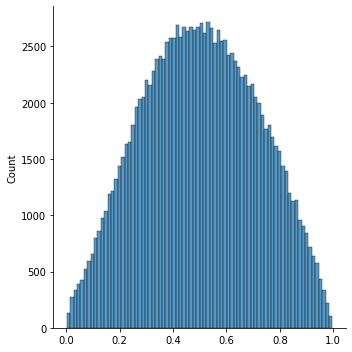

In [70]:
pred_test = np.mean(pred_tests, 0)

_ = sns.displot(pred_test)

#### Prepare Predictions

In [71]:
sub = df_test[['ID', 'Pred', 'TeamIdA', 'TeamIdB']].copy()
sub['Pred'] = pred_test

In [72]:
final_sub = sub[['ID', 'Pred']].copy()
final_sub.to_csv('submission.csv', index=False)

In [73]:
final_sub.describe()

,Pred
count,130683.000000
mean,0.502751
std,0.216256
min,0.001244
25%,0.339767
50%,0.501167
75%,0.666604
max,0.996816
